In [63]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader, Dataset, random_split
from matplotlib_inline import backend_inline
from d2l import torch as d2l


batch_size = 8
num_inputs, num_outputs, num_hiddens = 28, 2, 128
num_epochs = 1000
lr = 0.2


class MyDataset(Dataset):
    def __init__(self, csv_file, sep=',', header=None):
        self.data = pd.read_csv(csv_file, sep=sep, header=header)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,i):
        row = self.data.iloc[i]
        row = torch.tensor(row, dtype=torch.float32)
        features = row[:-1]
        label = row[-1].long()
        return (features, label)

data = MyDataset("result.csv")
test_size = int(0.2 * len(data))
train_size = len(data) - test_size
torch.manual_seed(4)
train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_iter = DataLoader(train_dataset, batch_size=batch_size)
test_iter = DataLoader(test_dataset, batch_size=batch_size)


net = nn.Sequential(
    nn.Flatten(), nn.Linear(num_inputs, num_hiddens), nn.ReLU(), nn.Linear(num_hiddens, num_outputs))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=lr)

In [42]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [43]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

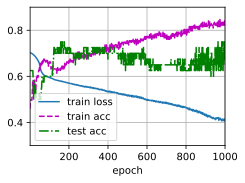

In [64]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)